In [1]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time
import math

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Load CIFAR10 Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

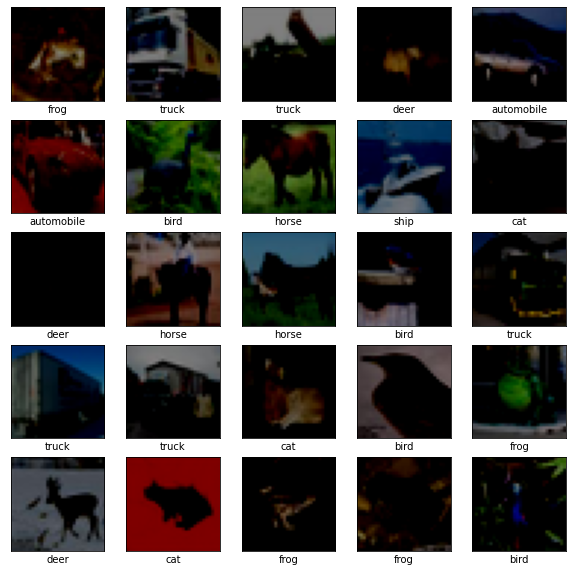

In [3]:
# Normalize pixel values to be between 0 and 1
x_train = (x_train / 255.0)- 0.5
x_test = (x_test / 255.0)- 0.5

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

#inputs and targets for kFold training set
inputs = x_train
targets = y_train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8]


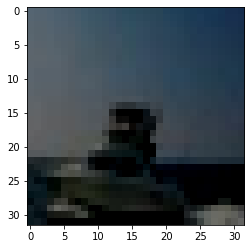

In [4]:
plt.imshow(x_train[100])
print(y_train[100])

In [5]:
#Quelle
#https://github.com/hiaghosh/Defensive-Distillation/blob/master/models/cifar10/cifar10.py
initial_learning_rate = 0.01

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * (drop_rate ** math.floor((1+epoch)/epochs_drop))

In [6]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    #Create and Train the Model for CIFAR10
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),  
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),  
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

    checkpoint_filepath = f'tmp/checkpoint{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate

    history = model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback, LearningRateScheduler(lr_step_decay, verbose=1)],
    )
    #model.load_weights(checkpoint_filepath)
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(model.metrics_names)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_mnist_kfold
    model.save(f'saved_models_cifar_kfold/base_model_cifar10_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 10s 24ms/step - loss: 2.1447 - accuracy: 0.1959 - val_loss: 1.6267 - val_accuracy: 0.3994
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 22ms/step - loss: 1.6028 - accuracy: 0.4042 - val_loss: 1.3644 - val_accuracy: 0.4956
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 22ms/step - loss: 1.3441 - accuracy: 0.5152 - val_loss: 1.1601 - val_accuracy: 0.5780
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 22ms/step - loss: 1.1862 - accuracy: 0.5776 - val_loss: 1.0935 - val_accuracy: 0.6040
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing le

Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.0746 - accuracy: 0.9752 - val_loss: 1.0518 - val_accuracy: 0.7888
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0676 - accuracy: 0.9771 - val_loss: 1.0972 - val_accuracy: 0.7842
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0639 - accuracy: 0.9798 - val_loss: 1.1020 - val_accuracy: 0.7834
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0603 - accuracy: 0.9793 - val_loss: 1.1006 - val_accuracy: 0.7844
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/st

352/352 [==============================] - 8s 23ms/step - loss: 0.1481 - accuracy: 0.9468 - val_loss: 0.8498 - val_accuracy: 0.7848
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1355 - accuracy: 0.9514 - val_loss: 0.8714 - val_accuracy: 0.7866
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1303 - accuracy: 0.9542 - val_loss: 0.8796 - val_accuracy: 0.7934
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1233 - accuracy: 0.9568 - val_loss: 0.8999 - val_accuracy: 0.7900
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.1082 - accuracy: 0.9624 - val_loss: 0.9123 - val_accuracy: 0.7930
Epoch 31/50

352/352 [==============================] - 8s 23ms/step - loss: 0.4577 - accuracy: 0.8351 - val_loss: 0.6483 - val_accuracy: 0.7830
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.4254 - accuracy: 0.8492 - val_loss: 0.6614 - val_accuracy: 0.7836
Epoch 15/50

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3932 - accuracy: 0.8598 - val_loss: 0.6650 - val_accuracy: 0.7810
Epoch 16/50

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3684 - accuracy: 0.8682 - val_loss: 0.6935 - val_accuracy: 0.7816
Epoch 17/50

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3389 - accuracy: 0.8799 - val_loss: 0.6957 - val_accuracy: 0.7752
Epoch 18/50

Epo

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 2.1357 - accuracy: 0.1957 - val_loss: 1.6469 - val_accuracy: 0.3964
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.5879 - accuracy: 0.4150 - val_loss: 1.4190 - val_accuracy: 0.4950
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.3587 - accuracy: 0.5052 - val_loss: 1.1989 - val_accuracy: 0.5700
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.1956 - accuracy: 0.5716 - val_loss: 1.1284 - val_accuracy: 0.6046
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing lea

Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.0736 - accuracy: 0.9755 - val_loss: 1.1328 - val_accuracy: 0.7786
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0689 - accuracy: 0.9774 - val_loss: 1.1641 - val_accuracy: 0.7818
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0624 - accuracy: 0.9790 - val_loss: 1.1700 - val_accuracy: 0.7856
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0594 - accuracy: 0.9801 - val_loss: 1.1582 - val_accuracy: 0.7840
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/st

352/352 [==============================] - 8s 23ms/step - loss: 0.1375 - accuracy: 0.9517 - val_loss: 0.8390 - val_accuracy: 0.7918
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1396 - accuracy: 0.9510 - val_loss: 0.9275 - val_accuracy: 0.7854
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1269 - accuracy: 0.9563 - val_loss: 0.9488 - val_accuracy: 0.7818
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1219 - accuracy: 0.9569 - val_loss: 0.9599 - val_accuracy: 0.7870
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.1060 - accuracy: 0.9630 - val_loss: 0.9500 - val_accuracy: 0.7890
Epoch 31/50

352/352 [==============================] - 8s 23ms/step - loss: 0.4570 - accuracy: 0.8378 - val_loss: 0.7152 - val_accuracy: 0.7594
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.4298 - accuracy: 0.8465 - val_loss: 0.6959 - val_accuracy: 0.7678
Epoch 15/50

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3979 - accuracy: 0.8581 - val_loss: 0.7135 - val_accuracy: 0.7670
Epoch 16/50

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3707 - accuracy: 0.8687 - val_loss: 0.7271 - val_accuracy: 0.7656
Epoch 17/50

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3383 - accuracy: 0.8775 - val_loss: 0.7557 - val_accuracy: 0.7732
Epoch 18/50

Epo

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 2.1354 - accuracy: 0.2011 - val_loss: 1.5940 - val_accuracy: 0.4046
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.5898 - accuracy: 0.4132 - val_loss: 1.3662 - val_accuracy: 0.5072
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.3613 - accuracy: 0.5098 - val_loss: 1.2539 - val_accuracy: 0.5564
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.1881 - accuracy: 0.5776 - val_loss: 1.0265 - val_accuracy: 0.6372
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing lea

Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.0685 - accuracy: 0.9760 - val_loss: 1.0748 - val_accuracy: 0.7864
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0657 - accuracy: 0.9773 - val_loss: 1.0689 - val_accuracy: 0.7870
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0603 - accuracy: 0.9790 - val_loss: 1.0841 - val_accuracy: 0.7848
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0563 - accuracy: 0.9821 - val_loss: 1.0776 - val_accuracy: 0.7830
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/st

352/352 [==============================] - 8s 23ms/step - loss: 0.1502 - accuracy: 0.9464 - val_loss: 0.8364 - val_accuracy: 0.7928
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1369 - accuracy: 0.9519 - val_loss: 0.8251 - val_accuracy: 0.7968
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1350 - accuracy: 0.9521 - val_loss: 0.8277 - val_accuracy: 0.7952
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 8s 23ms/step - loss: 0.1290 - accuracy: 0.9531 - val_loss: 0.9044 - val_accuracy: 0.7920
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.1110 - accuracy: 0.9594 - val_loss: 0.9068 - val_accuracy: 0.7940
Epoch 31/50

352/352 [==============================] - 8s 23ms/step - loss: 0.4710 - accuracy: 0.8330 - val_loss: 0.6941 - val_accuracy: 0.7714
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.4387 - accuracy: 0.8443 - val_loss: 0.7151 - val_accuracy: 0.7732
Epoch 15/50

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.4022 - accuracy: 0.8543 - val_loss: 0.6982 - val_accuracy: 0.7774
Epoch 16/50

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3730 - accuracy: 0.8690 - val_loss: 0.7080 - val_accuracy: 0.7738
Epoch 17/50

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 8s 23ms/step - loss: 0.3456 - accuracy: 0.8745 - val_loss: 0.7234 - val_accuracy: 0.7700
Epoch 18/50

Epo

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 2.1848 - accuracy: 0.1767 - val_loss: 1.6176 - val_accuracy: 0.4086
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.6204 - accuracy: 0.4029 - val_loss: 1.3433 - val_accuracy: 0.5194
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.3717 - accuracy: 0.5047 - val_loss: 1.2420 - val_accuracy: 0.5664
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 8s 23ms/step - loss: 1.1960 - accuracy: 0.5696 - val_loss: 1.0203 - val_accuracy: 0.6342
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing le

Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 23ms/step - loss: 0.0706 - accuracy: 0.9754 - val_loss: 1.0531 - val_accuracy: 0.7848
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0630 - accuracy: 0.9789 - val_loss: 1.0402 - val_accuracy: 0.7888
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0606 - accuracy: 0.9802 - val_loss: 1.0609 - val_accuracy: 0.7878
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/step - loss: 0.0575 - accuracy: 0.9801 - val_loss: 1.0566 - val_accuracy: 0.7886
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 8s 23ms/st

In [ ]:
#Quelle
#https://www.tensorflow.org/tutorials/images/transfer_learning

def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

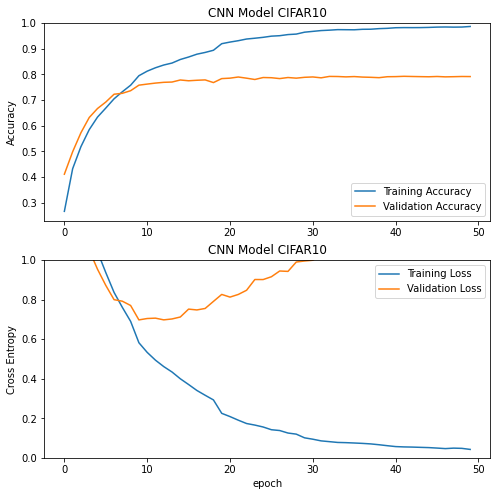

In [8]:
# Display training curve 
display_history(history, "CNN Model CIFAR10")

1


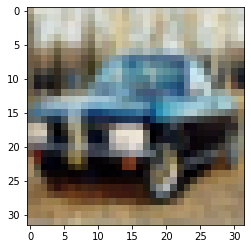

In [9]:
#Predict random image
y=model.predict(x_test)
print(np.argmax(y[1500]))
plt.imshow(x_test[1500], cmap=plt.cm.binary)

In [23]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_cifar_kfold/base_model_cifar10_{i}')
    model.load_weights(f'tmp/checkpoint{i}')

    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('accuracy.xlsx', sheet_name='kfold', index=False)

313/313 - 2s - loss: 1.1212 - accuracy: 0.7904
Accuracy: 79.04%
(10000, 10)
313/313 - 2s - loss: 1.1633 - accuracy: 0.7846
Accuracy: 78.46%
(10000, 10)
313/313 - 2s - loss: 1.1416 - accuracy: 0.7874
Accuracy: 78.74%
(10000, 10)
313/313 - 2s - loss: 1.1949 - accuracy: 0.7815
Accuracy: 78.15%
(10000, 10)
313/313 - 2s - loss: 0.8616 - accuracy: 0.7855
Accuracy: 78.55%
(10000, 10)
313/313 - 2s - loss: 1.1296 - accuracy: 0.7858
Accuracy: 78.58%
(10000, 10)
313/313 - 2s - loss: 1.0824 - accuracy: 0.7843
Accuracy: 78.43%
(10000, 10)
313/313 - 2s - loss: 1.0589 - accuracy: 0.7928
Accuracy: 79.28%
(10000, 10)
313/313 - 2s - loss: 1.1057 - accuracy: 0.7899
Accuracy: 78.99%
(10000, 10)
313/313 - 2s - loss: 1.1203 - accuracy: 0.7893
Accuracy: 78.93%
(10000, 10)


In [8]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [54]:
model = tf.keras.models.load_model(f'saved_models_cifar_kfold/base_model_cifar10_10')
model.load_weights(f'tmp/checkpoint10')

In [55]:
#Run an attack with foolbox
#Quelle
#https://github.com/bethgelab/foolbox
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test, dtype='int64')
attack_labels = tf.reshape(attack_labels, 10000)
attack_images = tf.convert_to_tensor(x_test, dtype='float32')

In [56]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox
predictions = model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Clean Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct

Clean Accuracy:  78.93 %


In [57]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
#PGD40 mit 20 Restarts, Table1
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 20)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate.xlsx', sheet_name='attack', index=False)

Batch:  0
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  1
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  2
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  3
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16

In [ ]:
acc = np.zeros(shape=(len(epsilons)))
#for loop über alle epsilons
for i in range(len(epsilons)):
    print("Epsilon:      ", epsilons[i])
    predictions = model.predict(raw[i])
    adv_predictions = np.argmax(predictions, axis = 1)
    print("Accuracy: ", np.mean(adv_predictions == attack_labels[:500])) # Accuracy of adversarial images
    print("--------------------------------------------------------------")
    print("")
    print("--------------------------------------------------------------")
    acc[i] = np.mean(adv_predictions == attack_labels[:500])
plt.plot(epsilons, acc)

In [ ]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Scikit Learn: ' + sklearn.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)